<h1 style="font-size:3rem;color:red;">Thesis Model Draft</h1>

# Predicting CO2 and N2O Levels Using ConvLSTM

In [ ]:
# pip install --user tensorflow

In [3]:
# pip install --user numpy==1.23.5

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Ensure reproducibility
#np.random.seed(42)

# path to file
#data_path = np.load(r'C:\Users\mhoque3\OneDrive - Cal State LA\desktop\thesis\Thesis 2nd sem\code needed\interpolatedCO2.npy')

# Full path to the interpolated CO2 data file
#data_path = r"C:\Users\mhoque3\OneDrive - Cal State LA\desktop\thesis\Thesis 2nd sem\code needed\interpolatedCO2.npy"

# Load the data
#data = load_data(data_path)


import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

# Define the load_data function
def load_data(data_path):
    data = np.load(data_path)  # Load the full dataset
    print(f"Loaded CO2 data with shape: {data.shape}")  # Should be (396, 200, 200)
    return data

# change this
data_path = "advanced-ai-project/Draft_Thesis_interpolated CO2.ipynb"

# Load the data
data = load_data(data_path)


/Users/jesusperez/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Check if data_path is a string
if isinstance(data_path, str):
    print("data_path is a valid string path.")
else:
    print(f"data_path is not a string. It is of type: {type(data_path)}")


data_path is a valid string path.


# Load and Preprocess the Data

In [6]:
# Load the interpolated CO2 data
def load_data(data_path):
    data = np.load(data_path)  # Load the full dataset
    print(f"Loaded CO2 data with shape: {data.shape}")  # Should be (396, 200, 200)
    return data

# Load the data
data = load_data(data_path)

# Normalize the data for better model performance
data = data / np.max(data)

# Prepare sequences for ConvLSTM (using 7-day sequences)
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps-1):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps+1])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(data)  # X shape: (389, 7, 200, 200), y shape: (389, 200, 200)

# Reshape X and y to include a channel dimension
X = X[..., np.newaxis]  # Shape: (389, 7, 200, 200, 1)
y = y[..., np.newaxis]  # Shape: (389, 200, 200, 1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

Loaded CO2 data with shape: (396, 200, 200)
X shape: (388, 7, 200, 200, 1), y shape: (388, 200, 200, 1)


# Define the ConvLSTM Model

In [7]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Conv3D, Flatten, Dense, Reshape

# Define the ConvLSTM model
model = Sequential()

# ConvLSTM layer
model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), input_shape=(7, 200, 200, 1),
                     padding='same', return_sequences=True))
model.add(BatchNormalization())

# Another ConvLSTM layer
model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), padding='same', return_sequences=False))
model.add(BatchNormalization())

# Reshape the output of the last ConvLSTM2D layer to 5D
# before connecting it to the Conv3D layer
model.add(Reshape((1, 200, 200, 4))) # Reshape to (batch_size, 1, height, width, channels)

# Directly connect Conv3D layer to the output of the last ConvLSTM
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same'))  # Final output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model.summary()

C:\Users\mhoque3\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 7, 200, 200, 8) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 200, 200, 8) │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 200, 200, 4)    │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 200, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 200, 200, 4) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 200, 200, 1) │           109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,525 (17.68 KB)

 Trainable params: 4,501 (17.58 KB)

 Non-trainable params: 24 (96.00 B)

In [8]:
X.shape, y.shape

((388, 7, 200, 200, 1), (388, 200, 200, 1))

# Train the Model

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [12]:
#Reshape y
y = y.reshape(y.shape[0], 1, 200, 200, 1)

# Fit the model
model.fit(X, y, batch_size=5, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 791ms/step - loss: 2.4228e-04 - mae: 0.0059 - val_loss: 3.0817e-04 - val_mae: 0.0122
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 762ms/step - loss: 2.2861e-04 - mae: 0.0059 - val_loss: 3.0996e-04 - val_mae: 0.0128
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 758ms/step - loss: 2.1670e-04 - mae: 0.0058 - val_loss: 3.0108e-04 - val_mae: 0.0128
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 756ms/step - loss: 2.0656e-04 - mae: 0.0056 - val_loss: 2.9791e-04 - val_mae: 0.0130
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 759ms/step - loss: 1.9731e-04 - mae: 0.0055 - val_loss: 2.5951e-04 - val_mae: 0.0114
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 784ms/step - loss: 1.8991e-04 - mae: 0.0054 - val_loss: 2.6455e-04 - val_mae: 0.0118
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 53s 857ms/step - loss: 1.8245e-04 - mae: 0.0052 - val_loss: 2.7042e-04 - val_mae: 0.0124
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 837ms/step - loss: 1.7627e-04 - mae: 0.0052 - val_loss: 2.8784e-04 - 

# Splitting Data for Testing

In [13]:
# Define the split ratio for test data
split_ratio = 0.8  # 80% training, 20% testing

# Calculate the split index
split_index = int(len(X) * split_ratio)

# Split the data into training and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(310, 7, 200, 200, 1), y_train=(310, 1, 200, 200, 1)
Test data shape: X_test=(78, 7, 200, 200, 1), y_test=(78, 1, 200, 200, 1)


# Evaluate the model

In [14]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 1.5392e-04 - mae: 0.0096
Test Loss: 0.0001538126089144498, Test MAE: 0.0096491239964962


# Prediction and Visualization

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


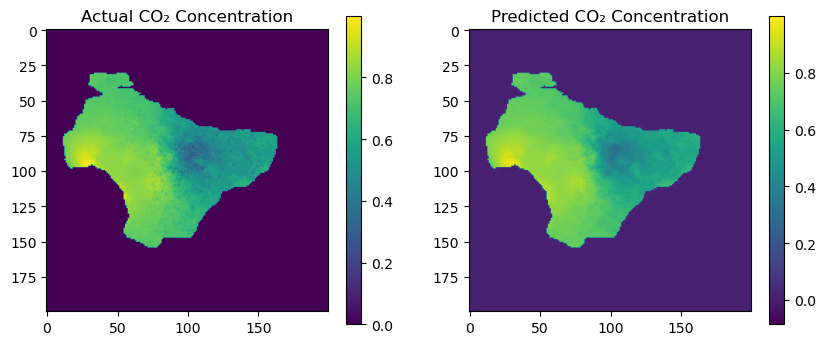

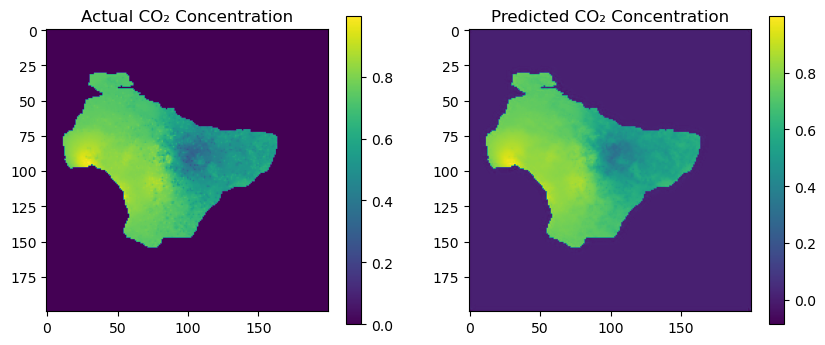

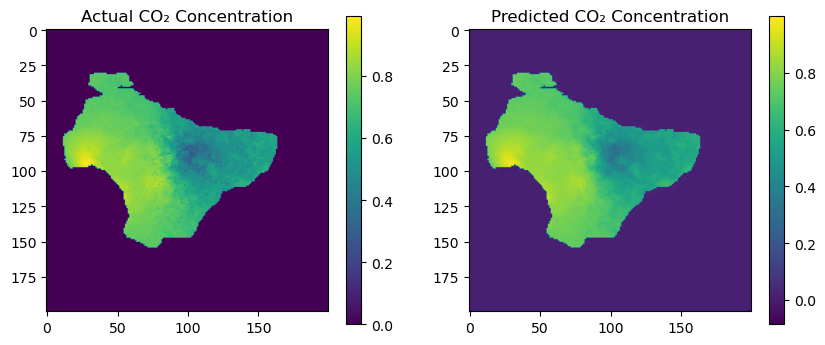

In [16]:
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs. predicted frames for a few samples
for i in range(3):  # Show 3 samples
    plt.figure(figsize=(10, 4))

    # Actual CO₂ concentration
    plt.subplot(1, 2, 1)
    plt.imshow(y_test[i, 0, :, :, 0], cmap='viridis')
    plt.title("Actual CO₂ Concentration")
    plt.colorbar()

    # Predicted CO₂ concentration
    plt.subplot(1, 2, 2)
    plt.imshow(y_pred[i, 0, :, :, 0], cmap='viridis')
    plt.title("Predicted CO₂ Concentration")
    plt.colorbar()

    plt.show()